# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

**data_arc_new.csv** — данные об электродах;

**data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);

**data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);

**data_gas_new.csv** — данные о продувке сплава газом;

**data_temp_new.csv** — результаты измерения температуры;

**data_wire_new.csv** — данные о проволочных материалах (объём);

**data_wire_time_new.csv** — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# План работы

1. Описание проекта и данных;


2. Загрузка данных:
   
   2.1 Исследование данных;
   
   2.2 Предобработка данных:
   
       2.2.1 Обработаем пропуски;
   
       2.2.2 Поменяем тип данных;
       
       2.2.3 Удалим аномалии;
   
   2.3 Подготовка данных:
   
       2.3.1 Генерирование признаков;
       
       2.3.2 Выделение целевого признака;
       
       2.3.3 Формирование обучающей и тестовой выборок;
       
3. Обучение моделей с использованием GridSearchCV:

    3.1 Модель LinearRegression;
    
    3.2 Модель RandomForestRegressor;
    
    3.3 Модель CatBoostRegressor;
    

4. Тестирование лучшей модели. Сравнение с константной моделью;


5. Вывод по проекту;


6. Отчет по проделанной работе.

# Загрузка данных

## Исследование данных

In [1]:
#Загружаем нужные нам библиотеки

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 26923

In [2]:
#Создаем функцию для отображения информации о данных

def study(data): 
    info = display(data.head(10)), data.info(), display(data.describe())

In [3]:
#Загружаем данные

data_arc = pd.read_csv('/datasets/data_arc_new.csv')

data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')

data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

data_gas = pd.read_csv('/datasets/data_gas_new.csv')

data_temp = pd.read_csv('/datasets/data_temp_new.csv')

data_wire = pd.read_csv('/datasets/data_wire_new.csv')

data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [4]:
study(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


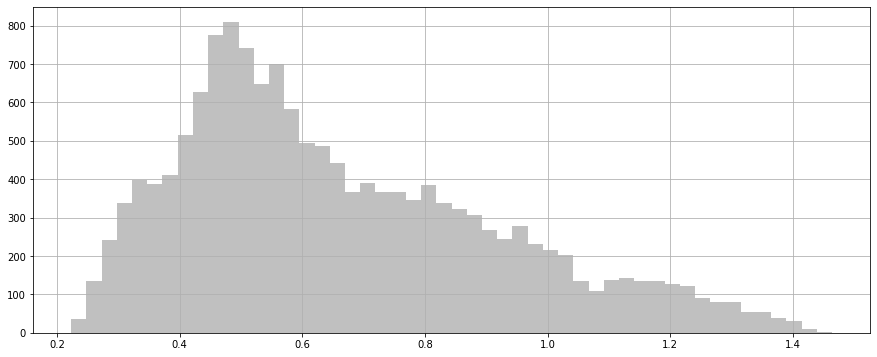

In [5]:
data_arc['Активная мощность'].hist(bins=50, figsize=(15,6), color='#C0C0C0');

In [6]:
data_arc['Реактивная мощность'].sort_values()

9780    -715.479924
709        0.153777
3290       0.153921
11794      0.155221
6130       0.156525
            ...    
8963       1.214912
14115      1.222632
8116       1.223063
3452       1.258628
2591       1.270284
Name: Реактивная мощность, Length: 14876, dtype: float64

Распределение значений активной мощности нормальное, а вот в значениях реактивной мощности видим аномалии - большая отрицательная мощность. Необходимо будет избавиться от данного значения. "Начало нагрева дугой" и "конец нагрева дугой" содержат в себе дату и время, необходима замена типа данных на datetime. Есть партии, по которым проводилось несколько замеров, так как в столбце "key" видим повторы. Также рассчитаем полную мощность, формула для расчета:

$$
S = \sqrt{(P^2 + Q^2)}
$$

где:

S - полная мощность,

P - активная мощность,

Q - реактивная мощность.

In [7]:
study(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [8]:
data_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

В этих данных у нас содержится информация о подаче сыпучих материалов. Среди номеров партии нет повторов. Можем заметить огромное количество пропусков, но это говорит нам о том, что данный материал просто не был добавлен. Заменим пропуски на 0. Удалим неинформативный столбец bulk_9, который состоит из всего 1 значения.

In [9]:
study(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [10]:
data_bulk_time['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

В этих данных у нас содержится информация о времени подачи сыпучих материалов. Номера партий не повторяются. Также заменим пропуски на 0.

In [11]:
study(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


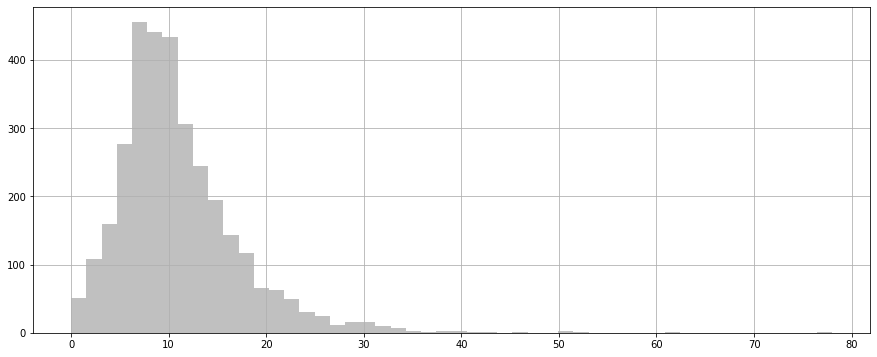

In [12]:
data_gas['Газ 1'].hist(bins=50, figsize=(15,6), color='#C0C0C0');

In [13]:
data_gas['key'].value_counts()

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

Распределение значий газа логнормально, номера партий не повторяются.

In [14]:
study(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [15]:
data_temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

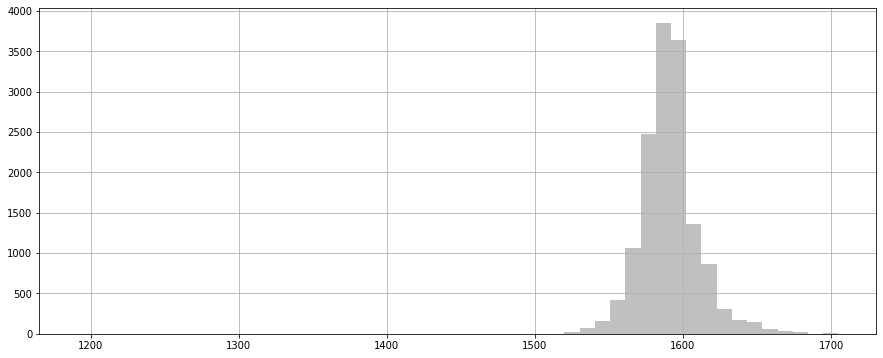

In [16]:
data_temp['Температура'].hist(bins=50, figsize=(15,6), color='#C0C0C0');

Нужно поменять тип данных столбца "Время замера" на datetime. Значения в стоблце "Температура" не могут быть меньше 1500(температура плавления стали), всё, что есть ниже этого значения считаем аномалиями и удаляем. В некоторых партиях производилось несколько замеров.

In [17]:
study(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [18]:
data_wire['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

In [19]:
study(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [20]:
data_wire_time['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

В данных data_wire и data_wire_time vожем заметить столбец Wire 5, который содержит всего 1 значение. Удалим его, чтобы не помешать дальнейшему обучению модели. Пропуски заменим на 0. Номера партий не повторяются.

# Вывод

Необходимо сделать предобработку и подготовку данных, а конкретнее:

1. Изменить регистр и названия столбцов, для более удобной работы с данными;

2. В некоторых столбцах поменять тип данных;

3. Обработать пропуски;

4. Удалить аномалии;

5. Произвести расчет полной мощности;

6. Нужные данные объединить в одну таблицу по номеру партии (столбец key);

7. Выделить целевой признак;

8. Разбить данные на 2 выборки: тестовую и обучающую.

## Предобработка данных

In [21]:
#Переименуем столбцы в данных, сохраним всё в новые датафреймы

arc_new = data_arc.rename(columns={'Начало нагрева дугой' : 'start_heating', 'Конец нагрева дугой' : 'end_heating', 
                                  'Активная мощность' : 'active_power', 'Реактивная мощность' : 'reactive_power'})

bulk_new = data_bulk.rename(columns={'Bulk 1' : 'bulk_1', 'Bulk 2' : 'bulk_2', 'Bulk 3' : 'bulk_3', 'Bulk 4' : 'bulk_4',
                                    'Bulk 5' : 'bulk_5', 'Bulk 6' : 'bulk_6', 'Bulk 7' : 'bulk_7', 'Bulk 8' : 'bulk_8',
                                    'Bulk 9' : 'bulk_9', 'Bulk 10' : 'bulk_10', 'Bulk 11' : 'bulk_11', 'Bulk 12' : 'bulk_12',
                                    'Bulk 13' : 'bulk_13', 'Bulk 14' : 'bulk_14', 'Bulk 15' : 'bulk_15'})

bulk_time_new = data_bulk_time.rename(columns={'Bulk 1' : 'bulk_1', 'Bulk 2' : 'bulk_2', 'Bulk 3' : 'bulk_3', 'Bulk 4' : 'bulk_4',
                                    'Bulk 5' : 'bulk_5', 'Bulk 6' : 'bulk_6', 'Bulk 7' : 'bulk_7', 'Bulk 8' : 'bulk_8',
                                    'Bulk 9' : 'bulk_9', 'Bulk 10' : 'bulk_10', 'Bulk 11' : 'bulk_11', 'Bulk 12' : 'bulk_12',
                                    'Bulk 13' : 'bulk_13', 'Bulk 14' : 'bulk_14', 'Bulk 15' : 'bulk_15'})

gas_new = data_gas.rename(columns={'Газ 1' : 'gas_1'})

temp_new = data_temp.rename(columns={'Время замера' : 'metering_time', 'Температура' : 'temp'})

wire_new = data_wire.rename(columns={'Wire 1' : 'wire_1', 'Wire 2': 'wire_2', 'Wire 3' : 'wire_3', 'Wire 4': 'wire_4',
                                    'Wire 5' : 'wire_5', 'Wire 6': 'wire_6', 'Wire 7' : 'wire_7', 'Wire 8': 'wire_8',
                                    'Wire 9': 'wire_9'})

wire_time_new = data_wire_time.rename(columns={'Wire 1' : 'wire_1', 'Wire 2': 'wire_2', 'Wire 3' : 'wire_3', 'Wire 4': 'wire_4',
                                    'Wire 5' : 'wire_5', 'Wire 6': 'wire_6', 'Wire 7' : 'wire_7', 'Wire 8': 'wire_8',
                                    'Wire 9' : 'wire_9'})

In [22]:
#Создадим функцию для вычисления полной мощности

def full_power(data):
        
    power = math.sqrt(data['active_power']**2 + data['reactive_power']**2)
    return power

In [23]:
#Отберем данные реактивной мощности, которые больше 0

arc_new = arc_new.query('reactive_power > 0')

#Изменим типы данных в столбцах start_heating и end_heating

arc_new = arc_new.astype({'start_heating': 'datetime64[ns]', 'end_heating' : 'datetime64[ns]'})

#Высислим затраченное время в секундах

arc_new['heating_time'] = (arc_new['end_heating'] - arc_new['start_heating']).dt.seconds

#Применим функцию для расчета полной мощности, создадим новый столбец и рассчитаем потребляемую мощность

arc_new['full_power'] = (arc_new.apply(full_power, axis=1)) * arc_new['heating_time']

#Удалим ненужные столбцы

arc_new = arc_new.drop(['active_power', 'reactive_power'], axis=1)

arc_new.info()

arc_new

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            14875 non-null  int64         
 1   start_heating  14875 non-null  datetime64[ns]
 2   end_heating    14875 non-null  datetime64[ns]
 3   heating_time   14875 non-null  int64         
 4   full_power     14875 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 697.3 KB


,key,start_heating,end_heating,heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,148,159.830252
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,157,83.537345
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,180,142.637202
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,184,237.983620
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,57,36.582120


In [24]:
#Заменим пропуски 0

bulk_new = bulk_new.fillna('0')

#Удалим неинформативный столбец

bulk_new = bulk_new.drop('bulk_8', axis=1)

#Изменим тип данных

cols = bulk_new.columns[1:16]

bulk_new[cols] = bulk_new[cols].astype('float')

bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_9   3129 non-null   float64
 9   bulk_10  3129 non-null   float64
 10  bulk_11  3129 non-null   float64
 11  bulk_12  3129 non-null   float64
 12  bulk_13  3129 non-null   float64
 13  bulk_14  3129 non-null   float64
 14  bulk_15  3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


In [25]:
#Заполним пропуски, изменим тип данных

cols = bulk_time_new.columns[1:15]

bulk_time_new[cols] = bulk_time_new[cols].fillna('2000-01-01 00:00:00')

bulk_time_new[cols] = bulk_time_new[cols].apply(pd.to_datetime, errors='coerce')

#Удалим неинформативный столбец

bulk_time_new = bulk_time_new.drop('bulk_8', axis=1)

bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   3129 non-null   datetime64[ns]
 2   bulk_2   3129 non-null   datetime64[ns]
 3   bulk_3   3129 non-null   datetime64[ns]
 4   bulk_4   3129 non-null   datetime64[ns]
 5   bulk_5   3129 non-null   datetime64[ns]
 6   bulk_6   3129 non-null   datetime64[ns]
 7   bulk_7   3129 non-null   datetime64[ns]
 8   bulk_9   3129 non-null   datetime64[ns]
 9   bulk_10  3129 non-null   datetime64[ns]
 10  bulk_11  3129 non-null   datetime64[ns]
 11  bulk_12  3129 non-null   datetime64[ns]
 12  bulk_13  3129 non-null   datetime64[ns]
 13  bulk_14  3129 non-null   datetime64[ns]
 14  bulk_15  2248 non-null   object        
dtypes: datetime64[ns](13), int64(1), object(1)
memory usage: 366.8+ KB


In [26]:
#Почистим пропуски, которые мы не сможем восстановить

temp_new = temp_new.dropna().reset_index(drop = True)

#Изменим тип данных

temp_new['temp'] = temp_new['temp'].astype('float')

temp_new = temp_new.astype({'metering_time' : 'datetime64[ns]'})

#Посмотрим данные, где температура будет меньше 1500

print(temp_new[temp_new['temp'] < 1500])

        key       metering_time    temp
4883    867 2019-06-06 08:03:39  1191.0
6784   1214 2019-06-18 08:01:03  1208.0
9050   1619 2019-07-03 02:34:41  1218.0
11495  2052 2019-07-25 08:49:15  1227.0
13987  2561 2019-08-12 18:49:29  1204.0


In [27]:
#Создадим список с ключами, которые нам необходимо удалить

droplist = [867, 1214, 1619, 2052, 2561]

temp_new = temp_new[temp_new['key'].isin(droplist) == False]

#Проверим уделение

print(temp_new[temp_new['temp'] < 1500])

Empty DataFrame
Columns: [key, metering_time, temp]
Index: []


In [28]:
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14643 entries, 0 to 14664
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   key            14643 non-null  int64         
 1   metering_time  14643 non-null  datetime64[ns]
 2   temp           14643 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 457.6 KB


In [29]:
#Удалим неинформативный столбец

wire_new = wire_new.drop('wire_5', axis=1)

#Поменяем типы данных

cols = wire_new.columns[1:9]

wire_new[cols] = wire_new[cols].fillna('0')

wire_new[cols] = wire_new[cols].astype('float')

wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


In [30]:
#Удалим неинформативный столбец

wire_time_new = wire_time_new.drop('wire_5', axis=1)

#Заполним пропуски и поменяем типы данных

cols = wire_time_new.columns[1:9]

wire_time_new[cols] = wire_time_new[cols].fillna('2000-01-01 00:00:00')

wire_time_new[cols] = wire_time_new[cols].apply(pd.to_datetime, errors='coerce')

wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3081 non-null   datetime64[ns]
 2   wire_2  3081 non-null   datetime64[ns]
 3   wire_3  3081 non-null   datetime64[ns]
 4   wire_4  3081 non-null   datetime64[ns]
 5   wire_6  3081 non-null   datetime64[ns]
 6   wire_7  3081 non-null   datetime64[ns]
 7   wire_8  3081 non-null   datetime64[ns]
 8   wire_9  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](8), int64(1)
memory usage: 216.8 KB


# Вывод

Переименовали столбцы во всех датафреймах. 

Отсортировали **arc_new**, откинув отрицательные значения реактивной мощности. Рассчитали и добавили потребляемую мощность, добавили время, затраченное на 1 итерацию (начало и конец нагрева), поменяли типы данных, удалили столбцы с активной и реактивной мощностями, так как нужные расчеты мы получили. 

**bulk_new** и **bulk_time_new** - заполнили пропуски '0' и датой-заглушкой '2000-01-01 00:00:00', поменяли типы данных и удалили неинформативный столбец **bulk_9**. 

В **time_new** удалили пропуски, так как восстановить мы их не сможем. Поменяли типы данных, а также отсортировали данные, оставили только те, в которых температура выше 1500. 

**wire_new** и **wire_time_new** - заполнили пропуски '0' и датой-заглушкой '2000-01-01 00:00:00', поменяли типы данных и удалили неинформативный столбец **wire_5**.

## Подготовка данных

In [31]:
#Сгруппируем данные, рассчитаем количество итераций нагрева, затраченное время и суммарную потребляемую мощность

heat_steel = arc_new.groupby('key').agg({'heating_time' : ['count','sum'],
                                         'full_power' : ['sum']})

heat_steel.columns = ['iter_heat', 'total_time', 'full_power']

heat_steel

,iter_heat,total_time,full_power
key,,,
1,5,1098,770.282114
2,4,811,481.760005
3,5,655,722.837668
4,4,741,683.455597
5,4,869,512.169934
...,...,...,...
3237,5,909,630.503534
3238,3,546,286.052252
3239,8,1216,941.538764


In [32]:
#Сгруппируем данные и найдем начальную и конечную температуры, а также количество итераций температуры

temp_steel = temp_new.groupby('key').agg({'temp' : ['first', 'last'],
                                         'metering_time' : ['count']})

temp_steel.columns = ['first_temp', 'last_temp', 'iter_temp']

temp_steel

,first_temp,last_temp,iter_temp
key,,,
1,1571.0,1613.0,6
2,1581.0,1602.0,5
3,1596.0,1599.0,6
4,1601.0,1625.0,5
5,1576.0,1602.0,5
...,...,...,...
3237,1569.0,1569.0,1
3238,1584.0,1584.0,1
3239,1598.0,1598.0,1


In [33]:
#Посмотрим данные, где был выполнен только 1 замер

print(temp_steel[temp_steel['iter_temp'] < 2])

      first_temp  last_temp  iter_temp
key                                   
195       1583.0     1583.0          1
279       1603.0     1603.0          1
2500      1539.0     1539.0          1
2501      1587.0     1587.0          1
2502      1583.0     1583.0          1
...          ...        ...        ...
3237      1569.0     1569.0          1
3238      1584.0     1584.0          1
3239      1598.0     1598.0          1
3240      1617.0     1617.0          1
3241      1586.0     1586.0          1

[740 rows x 3 columns]


In [34]:
#Избавимся от данных, где был выполнен 1 замер

temp_steel = temp_steel[temp_steel['iter_temp'] > 1]

print(temp_steel[temp_steel['iter_temp'] < 2])

Empty DataFrame
Columns: [first_temp, last_temp, iter_temp]
Index: []


In [35]:
temp_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_temp  2471 non-null   float64
 1   last_temp   2471 non-null   float64
 2   iter_temp   2471 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


In [36]:
#Объединим данные в одну таблицу

total_steel_data = (temp_steel.merge(heat_steel, how='inner', on = 'key')
                    .merge(wire_new, how='inner', on = 'key')
                    .merge(bulk_new, how='inner', on = 'key')
                    .merge(gas_new, how='inner', on = 'key'))

total_steel_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2325 non-null   int64  
 1   first_temp  2325 non-null   float64
 2   last_temp   2325 non-null   float64
 3   iter_temp   2325 non-null   int64  
 4   iter_heat   2325 non-null   int64  
 5   total_time  2325 non-null   int64  
 6   full_power  2325 non-null   float64
 7   wire_1      2325 non-null   float64
 8   wire_2      2325 non-null   float64
 9   wire_3      2325 non-null   float64
 10  wire_4      2325 non-null   float64
 11  wire_6      2325 non-null   float64
 12  wire_7      2325 non-null   float64
 13  wire_8      2325 non-null   float64
 14  wire_9      2325 non-null   float64
 15  bulk_1      2325 non-null   float64
 16  bulk_2      2325 non-null   float64
 17  bulk_3      2325 non-null   float64
 18  bulk_4      2325 non-null   float64
 19  bulk_5      2325 non-null  

Сгенерировали новые признаки: **first_temp**(начальное время), **last_temp**(конечное время), **iter_temp**(количество итераций температур), **iter_heat**(количество итераций цикла нагрева), **total_time**(затраченное время), **full_power**(суммарная потребляемая мощность). Объединили все признаки в одну таблицу. Посмотрим на корреляцию признаков, возможно, что некоторые признаки удалим за ненадобностью.

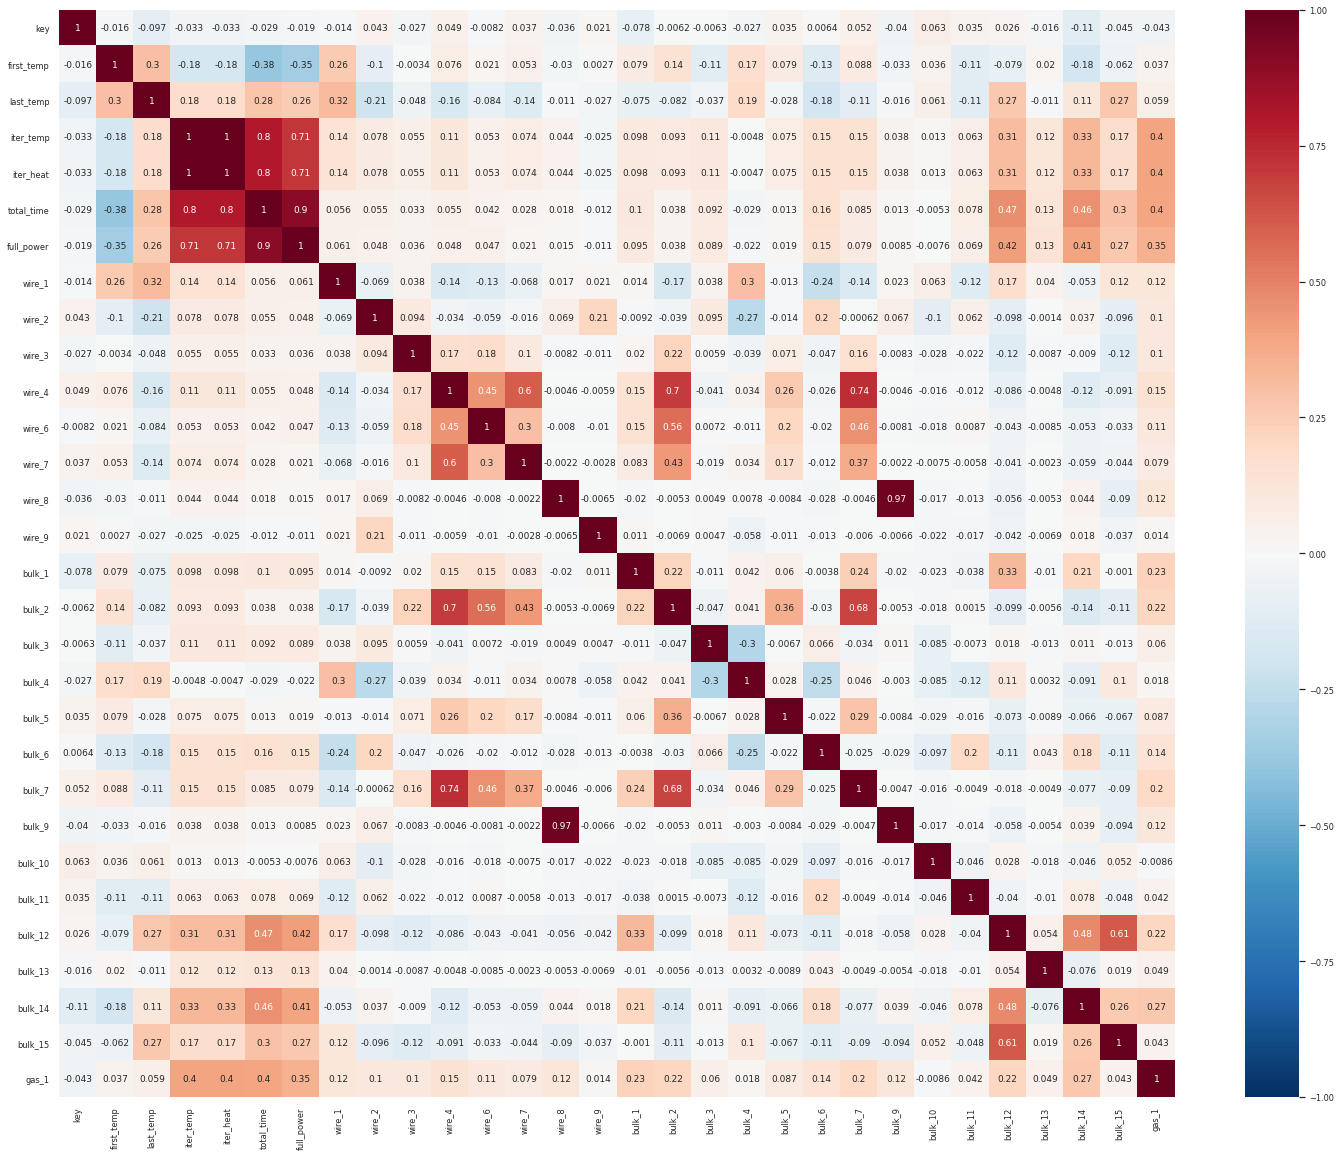

In [37]:
#Построим матрицу корреляций

sns.set(font_scale=0.75)
plt.figure(figsize=(25,20))
sns.heatmap(
    total_steel_data.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

Удалим один признак из пары, между которыми корреляция более 0.9. **total_time** и **full_power** корреляция 0.9, удалим **total_time**, так как мощность более важный признак для обучения. Также заметим корреляцию 0.98 между **bulk_9** и **wire_8**, избавимся от последнего, по информативности эти столбцы равносильны. Также сразу удалим **key**, он свою функцию выполнил.

In [38]:
#Удалим ненужные признаки

total_steel_data = total_steel_data.drop(['wire_8','key', 'total_time'], axis=1)

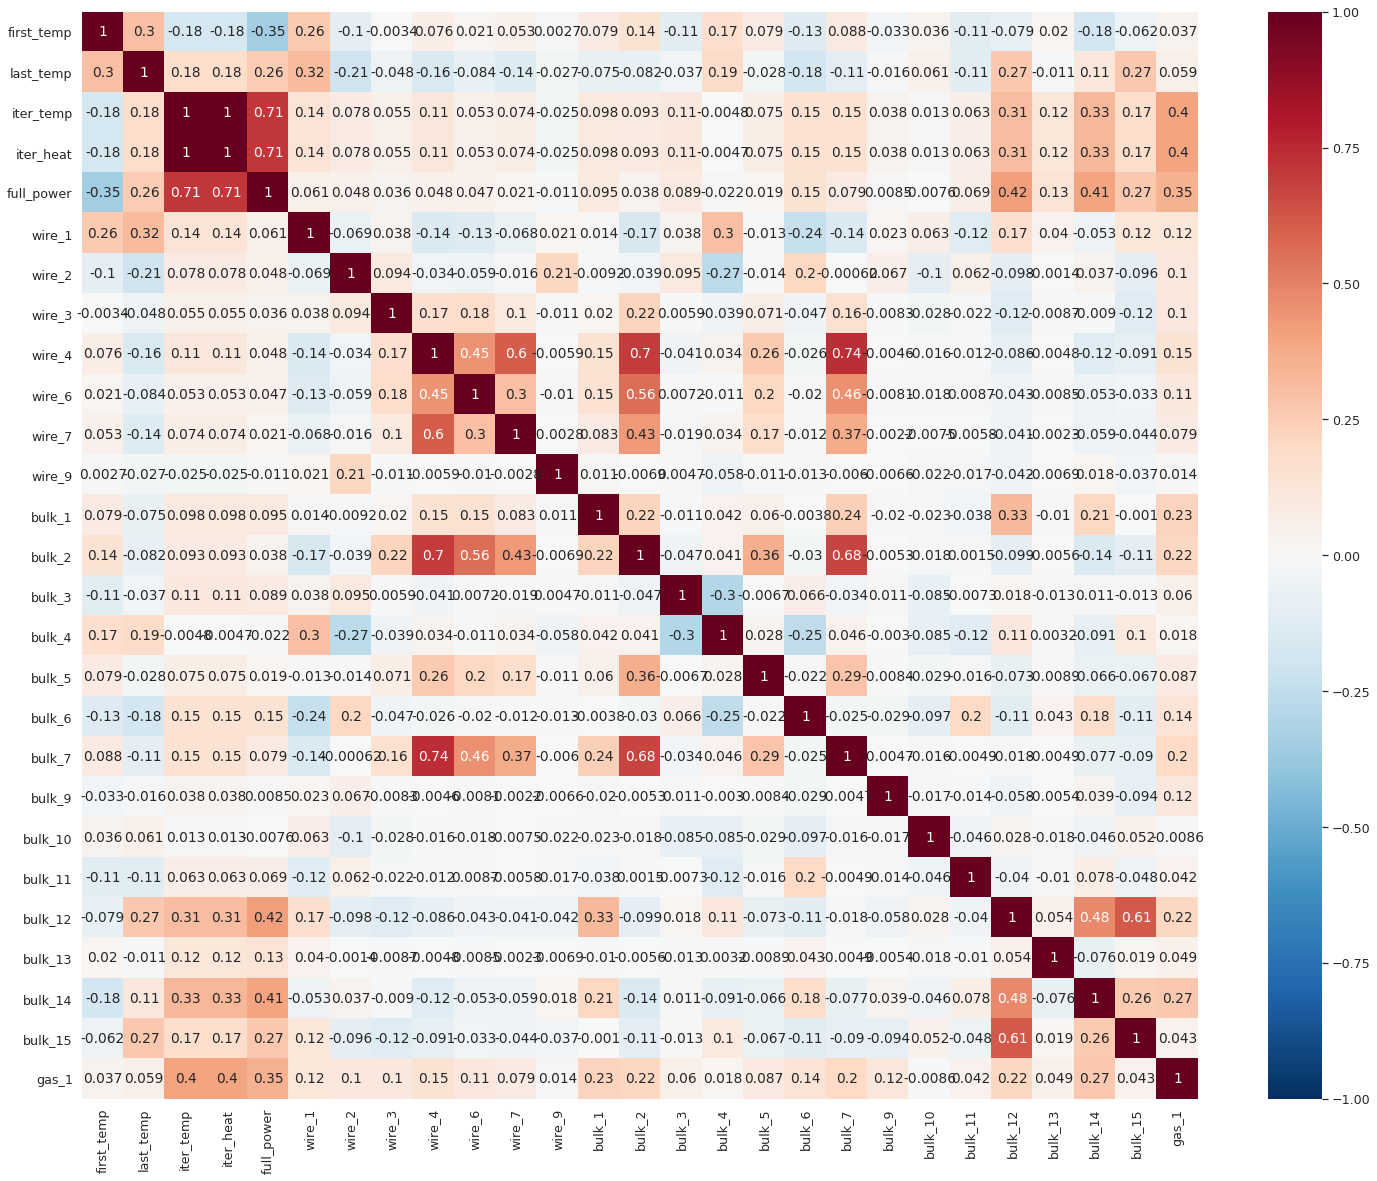

In [39]:
#Построим матрицу корреляции с новым набором признаков

sns.set(font_scale=1.15)
plt.figure(figsize=(25,20))
sns.heatmap(
    total_steel_data.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

Данные готовы для формирования выборок.

## Формирование выборок и целевого признака

In [40]:
#Сформируем набор признаков и целевой признак

features = total_steel_data.drop(['last_temp'], axis=1)

target = total_steel_data['last_temp']

In [41]:
#Разделим выборки на обучающую и тестовую

features_train, features_test, target_train, target_test = train_test_split(features,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE)

In [42]:
#Масштабируем признаки для линейной модели

scaler = StandardScaler()

scaler.fit(features_train)

features_train_sc = scaler.transform(features_train)

features_test_sc = scaler.transform(features_test)

display(features_train_sc)
display(features_test_sc)

array([[ 0.78305854, -0.42050149, -0.42050149, ..., -0.11926127,
        -0.18901887,  0.27242847],
       [ 0.61463392,  0.21133825,  0.21133825, ...,  0.74546382,
        -1.41702506,  0.71276726],
       [ 0.57252776, -1.68418099, -1.68418099, ..., -0.11926127,
        -0.20082662, -1.21036195],
       ...,
       [ 1.37254471, -0.42050149, -0.42050149, ..., -0.59548668,
         0.99175631, -0.0445958 ],
       [-0.73276306, -0.42050149, -0.42050149, ..., -0.30724498,
         1.2161036 , -0.68017073],
       [-0.64855075,  0.21133825,  0.21133825, ...,  3.15165537,
        -0.20082662,  0.76807949]])

array([[ 0.44620929,  0.21133825,  0.21133825, ...,  0.69533483,
         0.96814081,  1.11100103],
       [ 2.21466782, -1.05234124, -1.05234124, ..., -1.92390493,
        -1.41702506, -1.66782984],
       [-0.69065691,  0.843178  ,  0.843178  , ..., -1.92390493,
        -1.41702506,  0.54068908],
       ...,
       [ 0.40410314, -0.42050149, -0.42050149, ..., -0.67068017,
        -0.18901887, -0.39197488],
       [ 2.4251986 ,  3.37053698,  3.37053698, ...,  1.79817262,
         0.99175631,  1.74519606],
       [-1.15382462,  0.21133825,  0.21133825, ...,  0.90838304,
        -1.41702506,  0.16047656]])

Подготовили данные для обучения. Для линейных моделей произвели масштабирование признаков, для модели CatBoost воспользовались техникой OrdinalEncoder. Рассмотрим 3 модели: модель Линейной регрессии, модель Случайного леса и модель CatBoost.

## Обучение моделей

### LinearRegression

In [43]:
model_lr = LinearRegression()

params = [{'n_jobs' : range(1,3)}]

grd_lr = GridSearchCV(model_lr, params, cv=5, scoring='neg_mean_absolute_error')

grd_lr.fit(features_train_sc, target_train)

print('Гиперпараметры модели:', grd_lr.best_params_)
print('МАЕ:', abs(grd_lr.best_score_))

Гиперпараметры модели: {'n_jobs': 1}
МАЕ: 6.673980238836


### RandomForestRegressor

In [44]:
model_rf = RandomForestRegressor()

params = {'n_estimators': range(1,100,5),
          'max_depth': range(1,15,3), 
          'random_state' : [RANDOM_STATE]}

grd_rf = GridSearchCV(model_rf, params, cv=5, scoring='neg_mean_absolute_error')

grd_rf.fit(features_train_sc, target_train)

print('Гиперпараметры модели:', grd_rf.best_params_)
print('МАЕ:', abs(grd_rf.best_score_))

Гиперпараметры модели: {'max_depth': 10, 'n_estimators': 96, 'random_state': 26923}
МАЕ: 6.510253918619736


### CatBoostRegressor

In [45]:
model_cat = CatBoostRegressor() 
params = {'learning_rate':[0.1, 0.5, 0.8],
            'random_state':[RANDOM_STATE],
            'verbose':[1000]}

grd_cat = GridSearchCV(model_cat, params, cv=5, scoring='neg_mean_absolute_error')

grd_cat.fit(features_train, target_train)

print('Гиперпараметры модели:', grd_cat.best_params_)
print('МАЕ:', abs(grd_cat.best_score_))

0:	learn: 10.7919205	total: 50.5ms	remaining: 50.4s
999:	learn: 1.8807085	total: 3s	remaining: 0us
0:	learn: 10.7630322	total: 3.7ms	remaining: 3.7s
999:	learn: 1.8565776	total: 2.91s	remaining: 0us
0:	learn: 10.9155846	total: 3.45ms	remaining: 3.44s
999:	learn: 1.9713976	total: 2.89s	remaining: 0us
0:	learn: 11.0192034	total: 3.75ms	remaining: 3.75s
999:	learn: 1.9716626	total: 3s	remaining: 0us
0:	learn: 10.8397623	total: 5.86ms	remaining: 5.85s
999:	learn: 1.9684380	total: 3.13s	remaining: 0us
0:	learn: 9.9048628	total: 3.53ms	remaining: 3.53s
999:	learn: 0.0303989	total: 3.17s	remaining: 0us
0:	learn: 9.7795359	total: 5.52ms	remaining: 5.52s
999:	learn: 0.0290971	total: 2.92s	remaining: 0us
0:	learn: 10.0575503	total: 3.27ms	remaining: 3.27s
999:	learn: 0.0359414	total: 2.9s	remaining: 0us
0:	learn: 10.1267630	total: 3.09ms	remaining: 3.08s
999:	learn: 0.0386161	total: 2.94s	remaining: 0us
0:	learn: 9.9163388	total: 3.62ms	remaining: 3.62s
999:	learn: 0.0303119	total: 2.89s	remaini

Лучший показатель МАЕ: 6.510253918619736 у модели Случайного леса. Этого результата удалось достичь при параметрах 'max_depth': 10, 'n_estimators': 96, 'random_state': 26923. Проверим модель на тестовой выборке и на адекватность.

### Проверка лучшей модели на тестовой выборке. Сравнение с константной моделью.

In [46]:
predicted = grd_rf.predict(features_test_sc)

print('МАЕ:', mean_absolute_error(target_test,predicted))

МАЕ: 6.594744706858407


In [47]:
model_const = DummyRegressor(strategy="mean")

model_const.fit(features_train, target_train)

predicted = model_const.predict(features_test)
print('МАЕ:', mean_absolute_error(target_test,predicted))

МАЕ: 8.102285430381313


По условию задачи МАЕ <= 6.8, нам удалось достичь значения метрики МАЕ: 6.594744706858407 на тестовых данных. Модель прошла проверку на адекватность.

# Вывод 

1. Исследовали данные, определили для себя, что необходимо выполнить предобработку данных;


2. Выполнили предобработку, а именно:

   2.1 Переименовали столбцы во всех датафреймах;
  
   2.2 Отсеяли аномалии, привели к нужным типам данных, заполнили пропуски или избавились от них;
   
   2.3 Удалили неинформативные столбцы;


3. Подготовили данные:

   3.1 Сгенерировали новые признаки;
   
   3.2 Объединили признаки в один датафрейм;
   
   3.3 Посмотрели корреляцию между признаками, сделали выводы и избавились от некоторых признаков;
   

4. Сформировали выборки: обучающую и тестовую. Для линейных моделей выполнили масштабирование признаков;


5. Обучили модели и подобрали параметры при помощи GridSearchCV;


6. Выбрали лучшую модель (Случайный лес) и на тестовой выборке добились результата МАЕ: 6.594744706858407, что удовлетворяет условию задачи(не более 6.8). Модель адекватна.

# Отчет о проделанной работе

**Для решения задачи нами было выгружено 7 файлов:**

**data_arc_new.csv** — данные об электродах;

**data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);

**data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);

**data_gas_new.csv** — данные о продувке сплава газом;

**data_temp_new.csv** — результаты измерения температуры;

**data_wire_new.csv** — данные о проволочных материалах (объём);

**data_wire_time_new.csv** — данные о проволочных материалах (время).

При исследовании данных об электродах была замечена аномалия в виде большой отрицательной реактивной мощности. Пропусков не обнаружено. Обратили внимание, что необходимо будет изменить тип данных в столбцах, в которых хранится информация о времени начала и окончании нагрева дугой. В данных о подаче сыпучих материалов(объем и время) мы увидели огромное количество пропусков, что может говорить нам о том, что этот материал не был добавлен на том или ином этапе производства. Добавка **Bulk 8** была использована только в 1 партии, всего партий 3129. Из данных о газе мы можем понять, что подача газа была в 3239 партиях, повторов партий не выявлено. Изучили данные о измерениях температур, выявили аномальные значения в виде значений менее 1500(минимальная температура плавления для стали), также имеются пропуски. Партиии повторяются, значит можем сделать вывод, что в некоторых партиях были повторные замеры. Ознакомились данными о проволочных материалах, посмотрели их объем и время подачи. Обнаружили много пропусков в данных, но как и в случае с сыпучими материалами, это свидетельствуем о том, что материал просто не был добавлен. Добавка **Wire 5** фигурировала в 1 партии из 3081. Проанализировав загруженные данные, пришли к выводу, что перед обучением моделей необходимо провести предобработку данных и подготовить их.

Первое, что мы сделали в предобработке данных - переименовали столбцы во всех датафреймах. Отсортировали данные об электродах, откинув отрицательные значения реактивной мощности. Рассчитали и добавили потребляемую мощность, добавили время, затраченное на 1 итерацию (начало и конец нагрева), поменяли типы данных, удалили столбцы с активной и реактивной мощностями, так как нужные расчеты мы получили. Данные о сыпучих материалах(объем и время) - заполнили пропуски **'0'** и датой-заглушкой **'2000-01-01 00:00:00'**, поменяли типы данных и удалили неинформативный столбец **bulk_9**. В данных о измерениях температур удалили пропуски, так как восстановить мы их не сможем. Поменяли типы данных, а также отсортировали данные, оставили только те, в которых температура выше 1500. Данные о проволочных материалах - заполнили пропуски **'0'** и датой-заглушкой **'2000-01-01 00:00:00'**, поменяли типы данных и удалили неинформативный столбец **wire_5**.

Следующим нашим шагом стала подготовка данных. Сгенерировали новые признаки: начальное время, конечное время, количество итераций температур, количество итераций цикла нагрева, затраченное время, суммарная потребляемая мощность. Объединили все признаки в одну таблицу. Посмотрели корреляцию между признакими и отсеяли лишние, а именно - **затраченное время** и проволочный материал **wire_8**.

Разбили данные на выборки: **обучающую** и **тестовую**. Для линейных моделей сделали масштабирование признаков. Для обучения мы выбрали следующие модели: **Линейную регрессию**, **модель Случайного леса** и **CatBoost**. Провели автоматизированный подбор параметров с помощью **GridSearchCV**. Ключевой метрикой у нас является **МАЕ**. Нам удалось достичь следующих результатов:

**Линейная регрессия** - МАЕ: **6.673980238836**(подобранный гиперпараметр 'n_jobs': 1);

**Случайный лес** - МАЕ: **6.510253918619736**(подобранные гиперпараметры модели: {'max_depth': 10, 'n_estimators': 96, 'random_state': 26923});

**CatBoost** - МАЕ: **6.744606791785847**(подобранные гиперпараметры модели: {'learning_rate': 0.1, 'random_state': 26923, 'verbose': 1000}).

Лучшей стала **модель Случайного леса**, на тестовой выборке ее результат **МАЕ: 6.594744706858407**. Сравнили результат с констатной моделью **МАЕ: 8.102285430381313**, модель адекватна. Посмотрим, какие признаки оказались более важными для нашей задачи.

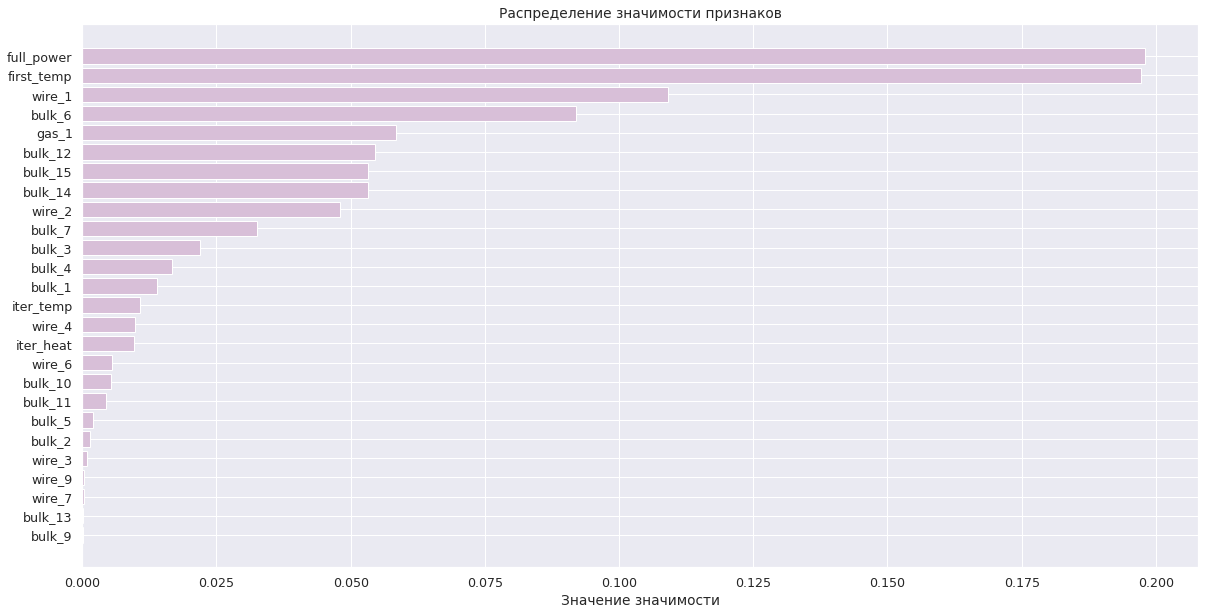

In [59]:
#Визуализируем важность признаков

features = features_train.columns
importances = grd_rf.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 10))
plt.title('Распределение значимости признаков')
plt.barh(range(len(indices)), importances[indices], color='#D8BFD8', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Значение значимости');

Отметим, что большое влияние имеют признаки - **потребляемая мощность** и **начальная температура**, менее важные признаки, которые также могут сказаться на результат добавки **wire_1** и **bulk_6**, следом за ними идет подача газа.  